In [67]:
import torch.nn
from datetime import datetime
import torchvision.models as models
import torch.nn.functional as F
import scipy.io
import torch
import numpy as np
from PIL import Image 
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm


In [109]:

def load_data(path_X, path_Y):
    data = scipy.io.loadmat(path_X) 
    print(data.keys())

    origin_X = np.array(data['x'].flat) # train
    # origin_X = np.array(data['denoise2_x']) # denoise train
    data = scipy.io.loadmat(path_Y) 
    origin_Y = data['y'][0].reshape(5000,-1)
    origin_Y_onehot= data['y_onehot'].reshape(5000,4,19)
    
    print ("origin_X shape: "+str(origin_X.shape))
    print ("origin_Y shape: "+str(origin_Y.shape))
    print ("origin_Y_onehot shape: "+str(origin_Y_onehot.shape))
 
    return origin_X,origin_Y,origin_Y_onehot

In [107]:
def resize_img (o_data,write,save):  
    index=0
    p_data=[]
    for i in o_data:
        name='resize_data_image/resize_x_'+str(index)+'.jpg'
        img = Image.fromarray(i, 'RGB')
        img=img.resize((130,50))
        if os.path.isfile(name) and save:      
            print (name+" is existed")    
        elif save:
            img.save(name)
        if write:
            p_data.append(np.array(img))       
        index+=1
        
    p_data=np.array(p_data)   
    print (p_data.shape)
    return p_data

In [111]:
path = "D:\\Casper\\OTHER\\Data\\identification code_database\\train.mat"
# path2 = "D:\\Casper\\OTHER\\Data\\identification code_database\\denoise_train2.mat"
origin_X,origin_Y,origin_Y_onehot=load_data(path, path)

train_rate=1 #change to 0.9
num_train_data=int(5000*train_rate)
print(origin_X.shape)
resize_x= resize_img(origin_X,True,False) # train
# resize_x= origin_X # denoise train

train_x_orig=resize_x.reshape(5000,50,130,-1)[0:num_train_data]
test_x_orig=resize_x.reshape(5000,50,130,-1)[num_train_data:]

x_train=train_x_orig.astype('float32')/255
x_test=test_x_orig.astype('float32')/255

y_train_onehot=origin_Y_onehot[0:num_train_data]
y_test_onehot=origin_Y_onehot[num_train_data:]

dict_keys(['__header__', '__version__', '__globals__', 'y_onehot', 'x', 'y'])
origin_X shape: (5000,)
origin_Y shape: (5000, 4)
origin_Y_onehot shape: (5000, 4, 19)
(5000,)
(5000, 50, 130, 3)


In [112]:
origin_X_tensor = torch.tensor(x_train, dtype=torch.float32)
origin_Y_tensor = torch.tensor(y_train_onehot, dtype=torch.float32)
# origin_Y_onehot_tensor = torch.tensor(y_train_onehot, dtype=torch.float32)

torch.Size([50, 130, 3])
torch.Size([50, 130, 3])
torch.Size([5000, 4, 19])


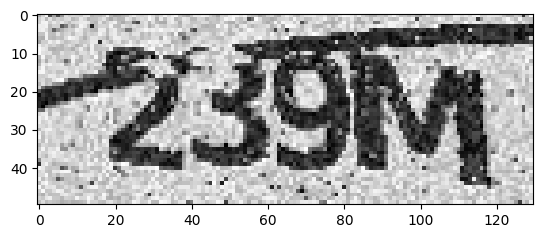

In [113]:
import matplotlib.pyplot as plt
print(origin_X_tensor[0].shape)
tensor = origin_X_tensor[0].permute(2, 0, 1)
tensor = tensor.permute(1, 2, 0)
print(tensor.shape)
# if tensor.min() < 0 or tensor.max() > 1:
    # tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())

plt.imshow(tensor)

# print(origin_Y_onehot_tensor[0])
print(origin_Y_tensor.shape)

In [114]:
# from torchvision import datasets, transforms

# transform = transforms.Compose([transforms.ToTensor(),
#                                     transforms.Normalize((0.5,), (0.5,))])
# train_loader = torch.utils.data.DataLoader(origin_X_tensor, batch_size=256, shuffle=True)
# test_loader = torch.utils.data.DataLoader(origin_Y_onehot_tensor, batch_size=256, shuffle=True)


In [115]:
origin_X_tensor_permuted = origin_X_tensor.permute(0, 3, 1, 2)


In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class SimpleCharCNN(nn.Module):
    def __init__(self):
        super(SimpleCharCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)  # Assuming grayscale images
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(24576, 512)  # Adjust the size according to your image size
        self.fc2 = nn.Linear(512, 76)  # 4 characters, each 26 possible letters

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [76]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCharCNN(nn.Module):
    def __init__(self):
        super(SimpleCharCNN, self).__init__()
        
        # Convolutional layers
        self.conv11_W1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=1, padding='same')
        self.conv12_W1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
        self.max_pool1_W1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv23_W1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding='same')
        self.conv24_W1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1)
        self.conv25_W1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1)
        self.bn1_W1 = nn.BatchNorm2d(128)
        self.max_pool2_W1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv36_W1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1, stride=1, padding='same')
        self.conv37_W1 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1)
        self.conv38_W1 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1)
        self.max_pool3_W1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv49_W1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding='same')
        self.conv410_W1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=1)
        self.bn2_W1 = nn.BatchNorm2d(512)
        self.max_pool4_W1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        
        # Dense (Fully Connected) Layers for each output branch
        self.fc_branches = nn.ModuleList([
            nn.Sequential(
                nn.Linear(in_features=3072, out_features=128),
                nn.ReLU(),
                nn.Dropout(0.25),
                nn.Linear(in_features=128, out_features=128),
                nn.ReLU(),
                nn.Linear(in_features=128, out_features=19),
                nn.Softmax(dim=1)
            ) for _ in range(4)
        ])

    def forward(self, x):
        x = F.relu(self.conv11_W1(x))
        x = F.relu(self.conv12_W1(x))
        x = self.max_pool1_W1(x)
        
        x = F.relu(self.conv23_W1(x))
        x = F.relu(self.conv24_W1(x))
        x = F.relu(self.conv25_W1(x))
        x = self.bn1_W1(x)
        x = self.max_pool2_W1(x)
        
        x = F.relu(self.conv36_W1(x))
        x = F.relu(self.conv37_W1(x))
        x = F.relu(self.conv38_W1(x))
        x = self.max_pool3_W1(x)
        
        x = F.relu(self.conv49_W1(x))
        x = F.relu(self.conv410_W1(x))
        x = self.bn2_W1(x)
        x = self.max_pool4_W1(x)
        
        x = self.flatten(x)
        x = self.dropout(x)
        
        # Branch out to the four different dense layers
        outputs = torch.stack([branch(x) for branch in self.fc_branches], dim = 1)
        
        return outputs

In [116]:
train_X = origin_X_tensor_permuted
train_Y_onehot_tensor = origin_Y_tensor.reshape(2500,-1)
print(train_X.shape)
print(train_Y_onehot_tensor.shape)

torch.Size([5000, 3, 50, 130])
torch.Size([2500, 152])


torch.Size([5000, 4])
tensor([ 3,  9, 15,  9])


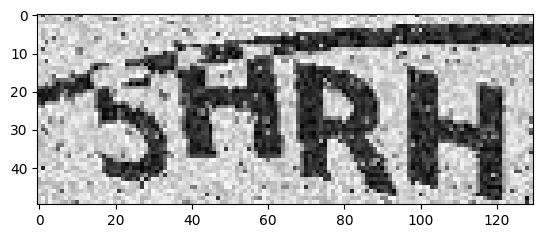

In [117]:
train_Y = torch.argmax(origin_Y_tensor, dim=-1)
print(train_Y.shape)
index = 20
print(train_Y[index])
plt.imshow(train_X[index].permute(1, 2, 0))

In [118]:
import random
from torch.utils.data import DataLoader, Subset
from datetime import datetime
from tqdm import tqdm
import numpy as np
import torch
from torch import optim, nn
import time
def get_dataloaders(dataset, train_ratio, val_ratio, batch_size):
    train_dataset = dataset
    val_dataset = dataset
    test_dataset = dataset
    # obtain training indices that will be used for validation
    num_train = len(test_dataset)
    indices = list(range(num_train))
    print("--------- INDEX checking ---------")
    print(f"Original: {indices[:5]}")
    random.shuffle(indices)
    print(f"Shuffled: {indices[:5]}")
    print("--------- INDEX shuffled ---------\n")

    split_train = int(np.floor(train_ratio * num_train))
    split_val = split_train + int(np.floor(val_ratio * (num_train-split_train)))
    train_idx, val_idx, test_idx = indices[0:split_train], indices[split_train:split_val], indices[split_val:]
    merge_dataset = Subset(train_dataset, train_idx)

    train_loader = DataLoader(merge_dataset, batch_size=batch_size)
    val_loader = DataLoader(Subset(val_dataset, val_idx), batch_size=batch_size)
    test_loader = DataLoader(Subset(test_dataset, test_idx), batch_size=batch_size)
    
    # check dataset
    print(f"Total number of samples: {num_train} datapoints")
    print(f"Number of train samples: {len(train_loader)} batches/ {len(train_loader.dataset)} datapoints")
    print(f"Number of val samples: {len(val_loader)} batches/ {len(val_loader.dataset)} datapoints")
    print(f"Number of test samples: {len(test_loader)} batches/ {len(test_loader.dataset)} datapoints")
    print(f"")
    
    dataloaders = {
        "train": train_loader,
        "val": val_loader,
        "test": test_loader,
    }
    return dataloaders

In [119]:
from torch.utils.data import TensorDataset
train_dataset = TensorDataset(train_X, train_Y)


In [120]:
def train3(model, epochs, batch_size, train_X, train_Y, reshape=False):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model = model.cuda()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for ii in tqdm(range(0, train_X.size(0), batch_size)):
            batch_X = train_X[ii:ii + batch_size].cuda()
            batch_Y = train_Y[ii:ii + batch_size].cuda()

            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch_X)  # Shape: [batch_size, 4, 19]
            if reshape:
                outputs = outputs.reshape(batch_Y.shape[0], 4, -1)
            loss = 0
            for jj in range(4):  # Iterate over each of the 4 targets
                # Compute loss for each target
                loss += criterion(outputs[:, jj, :], batch_Y[:, jj])
                
                # For accuracy calculation (Optional)
                _, predicted = torch.max(outputs[:, jj, :], dim=1)
                correct_predictions += (predicted == batch_Y[:, jj]).sum().item()
                total_samples += batch_Y.size(0)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculate the average loss and accuracy over the epoch
        epoch_loss = running_loss / len(range(0, train_X.size(0), batch_size))
        epoch_accuracy = correct_predictions / total_samples * 100  # Assuming accuracy calculation is desired

        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

In [121]:
def count_parameters(model):
    total_num = 0
    for parameter in model.parameters():
        if parameter.requires_grad:
            total_num += parameter.numel() 
    return total_num

In [128]:
def train(model_lists, model_name, loaders, phases=['train'], reshape=False, save_weight=False):
    model = model_lists[model_name]()
    if "res" in model_name:
        # model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) # denoise train
        num_features = model.fc.in_features
        model.fc = torch.nn.Linear(num_features, 76)

    print(f"Training model: {model_name}")
    model_parameters_amount = count_parameters(model)  # Assume this function is defined elsewhere
    print(f"Total parameters: {model_parameters_amount:,}")

    model = model.cuda()
    criterion = nn.CrossEntropyLoss()
    lr = 0.001
    optimizer = optim.Adam(model.parameters(), lr=lr)
    print(f"Learning rate={lr}")
    epochs = 25

    start = time.time()
    for epoch in range(epochs):
        for phase in phases:
            running_loss = 0.0
            correct_predictions = [0, 0, 0, 0]  # Track correct predictions for each of the 4 targets
            total_samples = 0
            model.train() if phase == 'train' else model.eval()  # Simplified model mode setting

            for inputs, labels in tqdm(loaders[phase]):  # Iterate over data.
                inputs, labels = inputs.cuda(), labels.cuda()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)  # [batch_size, 4, 19]
                    if reshape:
                        outputs = outputs.reshape(labels.shape[0], 4, -1)
                    loss = sum([criterion(outputs[:, i, :], labels[:, i]) for i in range(4)])  # Sum loss across all targets

                    if phase == 'train':  # backward + optimize only if in training phase
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item()
                for i in range(4):
                    _, predicted = torch.max(outputs[:, i, :], 1)
                    correct_predictions[i] += (predicted == labels[:, i]).sum().item()

                total_samples += labels.size(0)

            avg_loss = running_loss / total_samples
            top1_accuracy = [cp / total_samples * 100 for cp in correct_predictions]  # Accuracy per target
            print(f"Epoch [{epoch+1}/{epochs}], phase: {phase}, samples: {total_samples}, Loss: {avg_loss:.4f}, "
                  f"Top-1 Accuracies: {[f'{acc:.2f}%' for acc in top1_accuracy]}")

    end = time.time()
    print(f"Elapsed time: {end - start} seconds")

    if save_weight:
        torch.save(model.state_dict(), f'{model_name}.pt')  # It's often better to save state_dict
        print(f"Weight saved as: {model_name}.pt")

    return model

In [129]:
model_list ={
    "SimpleCharCNN": lambda: SimpleCharCNN(),
}
model_name = "SimpleCharCNN"
phases = ['train', 'val']
loaders = get_dataloaders(train_dataset, 0.8, 0.5, 32)
train(model_list, model_name, loaders, phases)

--------- INDEX checking ---------
Original: [0, 1, 2, 3, 4]
Shuffled: [1193, 4001, 2448, 3915, 298]
--------- INDEX shuffled ---------

Total number of samples: 5000 datapoints
Number of train samples: 125 batches/ 4000 datapoints
Number of val samples: 16 batches/ 500 datapoints
Number of test samples: 16 batches/ 500 datapoints

Training model: SimpleCharCNN
Total parameters: 4,845,196
Learning rate=0.001


  0%|          | 0/125 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [64, 1, 5, 5], expected input[32, 3, 50, 130] to have 1 channels, but got 3 channels instead

In [144]:
model_list ={
    "SimpleCharCNN": lambda: SimpleCharCNN(),
    "resnet18": lambda: models.resnet18(weights = models.ResNet18_Weights.DEFAULT),
    "resnet152": lambda: models.resnet152(weights = models.ResNet152_Weights.DEFAULT),
    "r6_btnk": lambda: mod_resnet(Bottleneck, [2, 2, 0, 0], channel_num_list=[16, 16, 16], num_classes=76)
}
model_name = "r6_btnk"
phases = ['train', 'val']
loaders = get_dataloaders(train_dataset, 0.8, 0.5, 32)
train(model_list, model_name, loaders, phases, reshape=True)

--------- INDEX checking ---------
Original: [0, 1, 2, 3, 4]
Shuffled: [834, 4467, 4629, 2934, 4927]
--------- INDEX shuffled ---------

Total number of samples: 5000 datapoints
Number of train samples: 125 batches/ 4000 datapoints
Number of val samples: 16 batches/ 500 datapoints
Number of test samples: 16 batches/ 500 datapoints

Training model: r6_btnk
Total parameters: 16,796
Learning rate=0.001


100%|██████████| 125/125 [00:00<00:00, 137.41it/s]


Epoch [1/25], phase: train, samples: 4000, Loss: 0.3652, Top-1 Accuracies: ['6.73%', '7.75%', '8.10%', '8.38%']


100%|██████████| 16/16 [00:00<00:00, 533.52it/s]


Epoch [1/25], phase: val, samples: 500, Loss: 0.3817, Top-1 Accuracies: ['6.40%', '11.00%', '6.40%', '9.20%']


100%|██████████| 125/125 [00:00<00:00, 160.31it/s]


Epoch [2/25], phase: train, samples: 4000, Loss: 0.3474, Top-1 Accuracies: ['12.60%', '14.95%', '15.72%', '16.88%']


100%|██████████| 16/16 [00:00<00:00, 400.13it/s]


Epoch [2/25], phase: val, samples: 500, Loss: 0.3600, Top-1 Accuracies: ['9.80%', '13.20%', '13.00%', '15.20%']


100%|██████████| 125/125 [00:00<00:00, 143.73it/s]


Epoch [3/25], phase: train, samples: 4000, Loss: 0.3312, Top-1 Accuracies: ['14.97%', '17.00%', '19.35%', '20.38%']


100%|██████████| 16/16 [00:00<00:00, 320.11it/s]


Epoch [3/25], phase: val, samples: 500, Loss: 0.3430, Top-1 Accuracies: ['11.20%', '16.40%', '17.20%', '20.60%']


100%|██████████| 125/125 [00:00<00:00, 175.41it/s]


Epoch [4/25], phase: train, samples: 4000, Loss: 0.3192, Top-1 Accuracies: ['16.05%', '19.30%', '22.35%', '23.93%']


100%|██████████| 16/16 [00:00<00:00, 533.52it/s]


Epoch [4/25], phase: val, samples: 500, Loss: 0.3647, Top-1 Accuracies: ['10.60%', '13.60%', '11.20%', '16.60%']


100%|██████████| 125/125 [00:00<00:00, 156.30it/s]


Epoch [5/25], phase: train, samples: 4000, Loss: 0.3076, Top-1 Accuracies: ['17.93%', '21.73%', '25.50%', '27.47%']


100%|██████████| 16/16 [00:00<00:00, 400.13it/s]


Epoch [5/25], phase: val, samples: 500, Loss: 0.3504, Top-1 Accuracies: ['13.20%', '17.00%', '13.40%', '19.80%']


100%|██████████| 125/125 [00:00<00:00, 158.28it/s]


Epoch [6/25], phase: train, samples: 4000, Loss: 0.2961, Top-1 Accuracies: ['19.05%', '23.20%', '26.45%', '29.25%']


100%|██████████| 16/16 [00:00<00:00, 533.52it/s]


Epoch [6/25], phase: val, samples: 500, Loss: 0.3275, Top-1 Accuracies: ['17.40%', '20.00%', '18.80%', '23.00%']


100%|██████████| 125/125 [00:00<00:00, 164.53it/s]


Epoch [7/25], phase: train, samples: 4000, Loss: 0.2860, Top-1 Accuracies: ['20.23%', '24.35%', '27.98%', '31.27%']


100%|██████████| 16/16 [00:00<00:00, 800.25it/s]


Epoch [7/25], phase: val, samples: 500, Loss: 0.2953, Top-1 Accuracies: ['20.80%', '24.40%', '25.80%', '29.40%']


100%|██████████| 125/125 [00:00<00:00, 162.39it/s]


Epoch [8/25], phase: train, samples: 4000, Loss: 0.2778, Top-1 Accuracies: ['21.00%', '25.40%', '29.62%', '32.40%']


100%|██████████| 16/16 [00:00<00:00, 533.52it/s]


Epoch [8/25], phase: val, samples: 500, Loss: 0.2859, Top-1 Accuracies: ['21.60%', '24.80%', '28.80%', '30.80%']


100%|██████████| 125/125 [00:00<00:00, 158.38it/s]


Epoch [9/25], phase: train, samples: 4000, Loss: 0.2712, Top-1 Accuracies: ['21.43%', '25.57%', '30.20%', '33.70%']


100%|██████████| 16/16 [00:00<00:00, 533.51it/s]


Epoch [9/25], phase: val, samples: 500, Loss: 0.2848, Top-1 Accuracies: ['20.00%', '23.20%', '29.00%', '32.60%']


100%|██████████| 125/125 [00:00<00:00, 156.30it/s]


Epoch [10/25], phase: train, samples: 4000, Loss: 0.2655, Top-1 Accuracies: ['22.27%', '26.55%', '31.13%', '35.38%']


100%|██████████| 16/16 [00:00<00:00, 533.50it/s]


Epoch [10/25], phase: val, samples: 500, Loss: 0.2911, Top-1 Accuracies: ['22.60%', '22.80%', '29.40%', '33.60%']


100%|██████████| 125/125 [00:00<00:00, 145.40it/s]


Epoch [11/25], phase: train, samples: 4000, Loss: 0.2606, Top-1 Accuracies: ['22.85%', '27.35%', '31.85%', '36.50%']


100%|██████████| 16/16 [00:00<00:00, 533.52it/s]


Epoch [11/25], phase: val, samples: 500, Loss: 0.2964, Top-1 Accuracies: ['23.60%', '22.80%', '27.00%', '32.20%']


100%|██████████| 125/125 [00:00<00:00, 158.28it/s]


Epoch [12/25], phase: train, samples: 4000, Loss: 0.2560, Top-1 Accuracies: ['23.40%', '28.30%', '32.38%', '37.90%']


100%|██████████| 16/16 [00:00<00:00, 800.26it/s]


Epoch [12/25], phase: val, samples: 500, Loss: 0.2992, Top-1 Accuracies: ['21.60%', '22.40%', '28.00%', '34.00%']


100%|██████████| 125/125 [00:00<00:00, 156.30it/s]


Epoch [13/25], phase: train, samples: 4000, Loss: 0.2517, Top-1 Accuracies: ['24.27%', '28.62%', '32.77%', '39.25%']


100%|██████████| 16/16 [00:00<00:00, 533.34it/s]


Epoch [13/25], phase: val, samples: 500, Loss: 0.2949, Top-1 Accuracies: ['22.60%', '24.60%', '28.80%', '35.80%']


100%|██████████| 125/125 [00:00<00:00, 158.27it/s]


Epoch [14/25], phase: train, samples: 4000, Loss: 0.2476, Top-1 Accuracies: ['25.15%', '29.12%', '33.27%', '40.52%']


100%|██████████| 16/16 [00:00<00:00, 533.45it/s]


Epoch [14/25], phase: val, samples: 500, Loss: 0.2909, Top-1 Accuracies: ['22.00%', '24.20%', '28.60%', '38.00%']


100%|██████████| 125/125 [00:00<00:00, 148.86it/s]


Epoch [15/25], phase: train, samples: 4000, Loss: 0.2438, Top-1 Accuracies: ['26.00%', '29.60%', '33.45%', '41.95%']


100%|██████████| 16/16 [00:00<00:00, 533.46it/s]


Epoch [15/25], phase: val, samples: 500, Loss: 0.2801, Top-1 Accuracies: ['22.20%', '26.00%', '29.20%', '40.00%']


100%|██████████| 125/125 [00:00<00:00, 150.65it/s]


Epoch [16/25], phase: train, samples: 4000, Loss: 0.2400, Top-1 Accuracies: ['26.72%', '30.18%', '34.12%', '43.58%']


100%|██████████| 16/16 [00:00<00:00, 800.28it/s]


Epoch [16/25], phase: val, samples: 500, Loss: 0.2784, Top-1 Accuracies: ['23.60%', '26.40%', '30.80%', '40.00%']


100%|██████████| 125/125 [00:00<00:00, 152.49it/s]


Epoch [17/25], phase: train, samples: 4000, Loss: 0.2364, Top-1 Accuracies: ['27.52%', '30.40%', '34.88%', '45.12%']


100%|██████████| 16/16 [00:00<00:00, 533.47it/s]


Epoch [17/25], phase: val, samples: 500, Loss: 0.2707, Top-1 Accuracies: ['25.60%', '27.20%', '33.00%', '42.20%']


100%|██████████| 125/125 [00:00<00:00, 152.49it/s]


Epoch [18/25], phase: train, samples: 4000, Loss: 0.2329, Top-1 Accuracies: ['28.30%', '30.78%', '35.62%', '46.52%']


100%|██████████| 16/16 [00:00<00:00, 400.16it/s]


Epoch [18/25], phase: val, samples: 500, Loss: 0.2697, Top-1 Accuracies: ['26.20%', '25.80%', '32.00%', '42.20%']


100%|██████████| 125/125 [00:00<00:00, 145.40it/s]


Epoch [19/25], phase: train, samples: 4000, Loss: 0.2295, Top-1 Accuracies: ['28.93%', '31.10%', '35.75%', '48.45%']


100%|██████████| 16/16 [00:00<00:00, 533.31it/s]


Epoch [19/25], phase: val, samples: 500, Loss: 0.2617, Top-1 Accuracies: ['28.00%', '26.60%', '31.80%', '42.40%']


100%|██████████| 125/125 [00:00<00:00, 150.65it/s]


Epoch [20/25], phase: train, samples: 4000, Loss: 0.2262, Top-1 Accuracies: ['30.08%', '31.90%', '36.02%', '50.02%']


100%|██████████| 16/16 [00:00<00:00, 533.42it/s]


Epoch [20/25], phase: val, samples: 500, Loss: 0.2563, Top-1 Accuracies: ['30.60%', '27.00%', '33.00%', '42.20%']


100%|██████████| 125/125 [00:00<00:00, 148.86it/s]


Epoch [21/25], phase: train, samples: 4000, Loss: 0.2228, Top-1 Accuracies: ['31.15%', '32.55%', '36.75%', '51.25%']


100%|██████████| 16/16 [00:00<00:00, 400.12it/s]


Epoch [21/25], phase: val, samples: 500, Loss: 0.2541, Top-1 Accuracies: ['29.80%', '27.20%', '32.00%', '42.60%']


100%|██████████| 125/125 [00:00<00:00, 152.49it/s]


Epoch [22/25], phase: train, samples: 4000, Loss: 0.2196, Top-1 Accuracies: ['32.07%', '32.88%', '37.15%', '53.30%']


100%|██████████| 16/16 [00:00<00:00, 400.17it/s]


Epoch [22/25], phase: val, samples: 500, Loss: 0.2582, Top-1 Accuracies: ['30.80%', '27.20%', '31.20%', '42.80%']


100%|██████████| 125/125 [00:00<00:00, 156.30it/s]


Epoch [23/25], phase: train, samples: 4000, Loss: 0.2164, Top-1 Accuracies: ['32.95%', '33.35%', '37.90%', '54.35%']


100%|██████████| 16/16 [00:00<00:00, 320.11it/s]


Epoch [23/25], phase: val, samples: 500, Loss: 0.2552, Top-1 Accuracies: ['31.40%', '27.00%', '33.60%', '43.60%']


100%|██████████| 125/125 [00:00<00:00, 156.30it/s]


Epoch [24/25], phase: train, samples: 4000, Loss: 0.2133, Top-1 Accuracies: ['33.92%', '33.42%', '37.82%', '55.80%']


100%|██████████| 16/16 [00:00<00:00, 533.46it/s]


Epoch [24/25], phase: val, samples: 500, Loss: 0.2550, Top-1 Accuracies: ['31.20%', '25.40%', '32.80%', '44.20%']


100%|██████████| 125/125 [00:00<00:00, 154.37it/s]


Epoch [25/25], phase: train, samples: 4000, Loss: 0.2103, Top-1 Accuracies: ['34.83%', '34.12%', '38.60%', '57.83%']


100%|██████████| 16/16 [00:00<00:00, 400.10it/s]

Epoch [25/25], phase: val, samples: 500, Loss: 0.2548, Top-1 Accuracies: ['32.60%', '25.40%', '32.00%', '44.40%']
Elapsed time: 21.245281457901 seconds


mod_resnet(
  (conv1): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1):

In [137]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out)

        return out
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x
class mod_resnet(nn.Module):
    def __init__(self, block, layers, channel_num_list, num_classes=1000):
        super(mod_resnet, self).__init__()
        self.in_channels = channel_num_list[0]
        self.conv1 = nn.Conv2d(3, channel_num_list[0], kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(channel_num_list[0])
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, channel_num_list[1], layers[0])
        self.layer2 = self._make_layer(block, channel_num_list[2], layers[1], stride=2)
        # self.layer3 = self._make_layer(block, channel_num_list[3], layers[2], stride=2)
        # self.layer4 = self._make_layer(block, channel_num_list[4], layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(channel_num_list[-1] * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        # x = self.layer3(x)
        # x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x